<a href="https://colab.research.google.com/github/MohrezSheikh/Deep-Transfer-Learning-with-CNN-for-EEG-signals-in-diagnosing-Schizophrenia-patients./blob/master/VGG16%2BXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install keras
!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import glob
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
import os
import seaborn as sns
from keras.layers import Reshape
from sklearn.model_selection import train_test_split
from keras.applications import VGG16,VGG19
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder

In [6]:
# images path
healthy_save_path = '/content/drive/MyDrive/eeg/NewHealthy'
schizophrenia_save_path = '/content/drive/MyDrive/eeg/NewSchizophrenia'

In [7]:
healthy_folder = healthy_save_path
schizophrenia_folder = schizophrenia_save_path

# Define functions for loading and processing images
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
           # best : target_size=(224, 224) run it in IDE
            img =image.load_img(os.path.join(folder, filename), target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(0 if folder == healthy_folder else 1)
    return np.array(images), np.array(labels)

X_healthy, y_healthy = load_images(healthy_folder)
X_schizophrenia, y_schizophrenia = load_images(schizophrenia_folder)

# Merge datasets
X = np.concatenate((X_healthy, X_schizophrenia), axis=0)
y = np.concatenate((y_healthy, y_schizophrenia), axis=0)

# Shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
print('X Shape: ', X.shape)

X Shape:  (1142, 224, 224, 3)


In [8]:
input_shape = (224, 224, 3)
# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 4s 0us/step


In [11]:
for layer in VGG_model.layers:
  layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
feature_extractor = VGG_model.predict(X_train)

25/25 [==============================] - 17s 231ms/step


In [14]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features

In [15]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
X_test_feature = VGG_model.predict(X_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

11/11 [==============================] - 4s 371ms/step


In [25]:
prediction = model.predict(X_test_features)

Accuracy: 0.7376093294460642


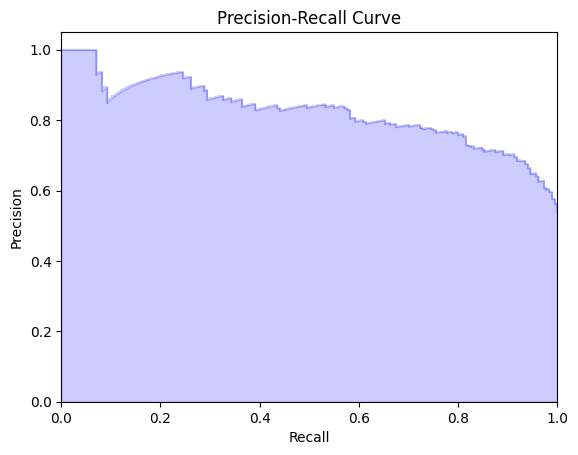

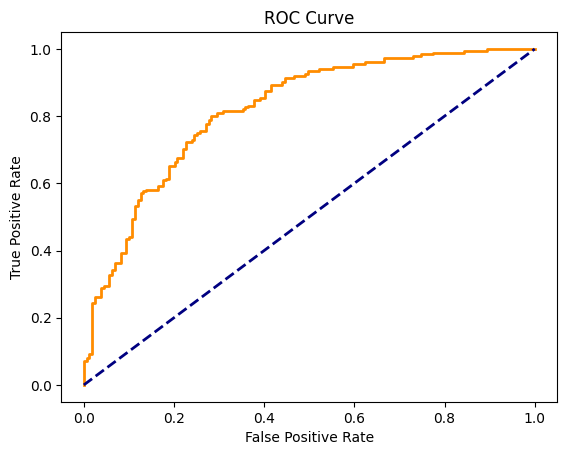

AUC Score: 0.8201394585726005


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Evaluate accuracy
accuracy = metrics.accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)

# Get predicted probabilities
probs = model.predict_proba(X_test_features)[:, 1]

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, probs)

# Calculate AUC score
auc_score = roc_auc_score(y_test, probs)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print AUC score
print("AUC Score:", auc_score)